In [8]:
import json

In [9]:
ls

attribute_descriptions.txt
blmki_aib.json
blmki_angewandtekunst.json
blmki_aussereuropaeischekulturen.json
blmki_ausstellungreformationerfolgekriege.json
blmki_bildarchivstaufen.json
blmki_bilderbogen.json
blmki_coronasammlung.json
blmki_fotofilmavmedien.json
blmki_mittelalter.json
blmki_musikautomaten.json
blmki_numismatik.json
blmki_numismatiksaenger.json
blmki_objektemuseumammarkt.json
blmki_postkarten.json
blmki_sammlungeckert.json
blmki_sammlungknobloch.json
blmki_sammlunglankheit.json
blmki_sammlunglankheitml.json
blmki_sammlungstopfel.json
blmki_staatlichemajolikamanufaktur.json
blmki_thronsaal.json
blmki_tuerkenbeute.json
cleaning-Copy1.ipynb
describe_keys.ipynb
describe_keywords.ipynb
exploration-Copy1.ipynb
exploration.ipynb
keywords/
person_types.txt
transform_to_unqualified_dc.ipynb
Untitled.ipynb


In [10]:
json_paths = [
    #"blmki_aib.json",
    "blmki_angewandtekunst.json",
    #"blmki_aussereuropaeischekulturen.json",
    #"blmki_ausstellungreformationerfolgekriege.json",
    #"blmki_bildarchivstaufen.json",
    #"blmki_bilderbogen.json",
    #"blmki_coronasammlung.json",
    #"blmki_fotofilmavmedien.json",
    #"blmki_mittelalter.json",
    #"blmki_musikautomaten.json",
    #"blmki_numismatik.json",
    #"blmki_numismatiksaenger.json",
    #"blmki_objektemuseumammarkt.json",
    #"blmki_postkarten.json",
    #"blmki_sammlungeckert.json",
    #"blmki_sammlungknobloch.json",
    #"blmki_sammlunglankheit.json",
    #"blmki_sammlunglankheitml.json",
    #"blmki_sammlungstopfel.json",
    #"blmki_staatlichemajolikamanufaktur.json",
    #"blmki_thronsaal.json",
    #"blmki_tuerkenbeute.json",
]

In [11]:
for json_path in json_paths:
    with open(json_path, 'r') as f:
        data = json.load(f)


In [12]:
records = data['records']
records[1]

{'imdasid': '9884281D4F13CBC1CFB169AD5E54929A',
 'typ': 'objekt',
 'sammlung': [{'sammlung': 'Angewandte Kunst seit 1900',
   'domaene': 'Kunst- & Kulturgeschichte',
   'museum': 'Badisches Landesmuseum'}],
 'objektid': '1221',
 'eingangsdatum': '2000-10-12 00:00:00',
 'eingangsart': 'Schenkung',
 'inventarisierungsdatum': '2002-04-30 00:00:00',
 'inventarnummer': '2000/1565',
 'objekttitel_de': 'Entsafter',
 'publikum': '0',
 'beschreibung_de': 'Braun. Saftzentrifuge. Multipress. Bestehend aus zwei Rundquadern, die durch einen Metallbügel miteinander verbunden sind, der in den unteren von den beiden Rundquadern eingearbeitet ist; dieser steht auf drei Gummifüßchen. In den oberen Rundquader ist ein Trichter eingelassen; der untere Rand des Quaders mündet in eine Schütte. Auf dem Oberteil bezeichnet: Braun Multipress Unterteil (Motorblock) dunkelrot, Oberteil (Elfenbeinweiß)',
 'stueck': '1',
 'title_de': 'Braun Saftzentrifuge "Multipress"',
 'eigenname': 'Saftzentrifuge "Multipress"',


In [66]:
def extract_if_exists(record, dc, from_attrib, to_attrib):
    if to_attrib not in dc:
        dc[to_attrib] = []
    if from_attrib in record:
        dc[to_attrib].append(record[from_attrib])

def extract_keywords(record, dc):
    dc['subject'] = []
    if 'schlagworte' in record:
        for keyword in record['schlagworte']:
            dc['subject'].append(keyword['term'])
        
def extract_creator(record, dc):
    creator_types = ['Entwerfer', 'Hersteller']
    dc['creator'] = []
    if 'person' in record:
        for person in record['person']:
            if person['typ'] in creator_types:
                if 'anzeigename' in person:
                    dc['creator'].append(person['anzeigename'])
                else:
                    first_name = person['vorname'] if 'vorname' in person else ''
                    last_name = person['nachname'] if 'nachname' in person else ''
                    dc['creator'].append(f"{first_name} {last_name}")
            
def extract_date(record, dc):
    date_map = {'anfangsdatum': 'start_date', 'enddatum': 'end_date', 'eingangsdatum': 'inventory_date'}
    dc['date'] = []
    for key in date_map:
        if key in record:
            dc['date'].append({'type': date_map[key], 'value': record[key]})
    
def extract_format(record, dc):
    mass_map = {'Breite': 'width', 'Durchmesser': 'diameter', 'Höhe': 'height'}
    dc['format'] = []
    if 'masse' in record:
        mass = record['masse']
        for entry in mass:
            if entry['typ'] in mass_map:
                dc['format'].append({'type': mass_map[entry['typ']], 'value': entry['value'], 'unit': entry['unit'],
                                     'note': entry['notiz'] if 'notiz' in entry else None})

def extract_coverage(record, dc):
    location_map = {'Herstellungsort': 'creation_location'}
    dc['coverage'] = []
    if 'ort' in record:
        for ort in record['ort']:
            if ort['typ'] in location_map:
                dc['coverage'].append({'type': location_map[ort['typ']], 'term': ort['term'], 
                                       'lon': ort['lon'] if 'lon' in ort else None, 
                                       'lat': ort['lat'] if 'lat' in ort else None})
    
def extract_media(record, dc):
    dc['media'] = []
    if 'medium' in record:
        for medium in record['medium']:
            if medium['typ'] == 'Bild':
                uri = medium['uri'].replace("Z:\\Objekt\\Bild\\", "images/")
                uri = uri.replace("\\", "/")
                dc['media'].append({'type': 'image', 'path': uri})

def extract_description(record, dc):
    dc['description'] = ''
    if 'beschreibung_de' in record:
        dc['description'] = record['beschreibung_de']

def extract_collection(record, dc):
    dc['collection'] = []
    for collection in record['sammlung']:
        dc['collection'].append({'name': collection['sammlung'], 'domain': collection['domaene'], 'museum': collection['museum']})

def record_to_dc(record):
    dc = dict()
    extract_collection(record, dc)
    extract_if_exists(record, dc, 'title_de', 'title')
    extract_if_exists(record, dc, 'objekttitel_de', 'title')
    extract_if_exists(record, dc, 'schlagworte', 'subject')
    extract_description(record, dc)
    extract_keywords(record, dc)
    extract_creator(record, dc)
    extract_date(record, dc)
    extract_format(record, dc)
    dc['identifier'] = record['objektid']
    dc['publisher'] = ['Badisches Landesmuseum']
    dc['language'] = ['de']
    extract_coverage(record, dc)
    extract_media(record, dc)
    extract_collection(record, dc)
    return dc

In [67]:
dc = record_to_dc(records[15])
dc

{'collection': [{'name': 'Angewandte Kunst seit 1900',
   'domain': 'Kunst- & Kulturgeschichte',
   'museum': 'Badisches Landesmuseum'}],
 'title': ['Vase'],
 'subject': [],
 'description': 'Hochrechteckige Kastenform, von gewölbter Schulter über zweistufigen Halsaufbau zum zylindrischen Hals in die Doppelrand-Öffnung übergehend. - Steinzeug, schamottehaltrig, gebaut. Oxydationsbrand im Elekroofen bei 1285° C. Durch Pinselauftrag von Glasur aus Manganton, Malachitgestein und Apfelbaumasche grün-braune Strukturen, am Hals durch Manganton mattes Schwarz, Signatur: Ritzzechen LR 89, Werknummer: Pinselzeichen 61',
 'creator': ['Lotte Reimers'],
 'date': [{'type': 'start_date', 'value': '1989.0101'},
  {'type': 'end_date', 'value': '1989.1231'},
  {'type': 'inventory_date', 'value': '1993-11-02 00:00:00'}],
 'format': [{'type': 'height', 'value': '38.2', 'unit': 'cm', 'note': None},
  {'type': 'width', 'value': '16', 'unit': 'cm', 'note': None}],
 'identifier': '13240',
 'publisher': ['Badi

In [89]:
def folder_from_path(path):
    start_pos = path.find("/") + 1
    end_pos = path.find("/", start_pos)
    return path[start_pos:end_pos]

[folder_from_path(media['path']) for media in dc['media']]

[]

In [90]:
dcs = [record_to_dc(record) for record in records]

In [91]:
folders = set()
for dc in dcs:
    folders.update(set(folder_from_path(media['path']) for media in dc['media']))

In [92]:
folders_subset = set()
num_folders = 10
i = 0
for folder in folders:
    if folder != '' and i < num_folders:
        folders_subset.add(folder)
        i += 1
folders_subset

{'1967 00',
 '1970 00',
 '1983 00',
 '1996 00',
 '2020 00',
 '2021 00',
 'Dep 2002',
 'LGA 00',
 'LGA 01',
 'LGA 02'}

In [93]:
def dc_in_folders(dc, folders):
    for media in dc['media']:
        if folder_from_path(media['path']) not in folders:
            return False
    return True

dcs_filtered = [dc for dc in dcs if dc_in_folders(dc, folders_subset)]
dcs_filtered

[{'collection': [{'name': 'Angewandte Kunst seit 1900',
    'domain': 'Kunst- & Kulturgeschichte',
    'museum': 'Badisches Landesmuseum'}],
  'title': ['Plakatentwurf', 'Plakat'],
  'subject': [],
  'description': 'Plakat für die DLW, Deutsche Linoleum-Werke, mit Mädchen mit Puppe',
  'creator': [],
  'date': [{'type': 'start_date', 'value': '1945.0101'},
   {'type': 'end_date', 'value': '1955.1231'},
   {'type': 'inventory_date', 'value': '2001-09-27 00:00:00'}],
  'format': [],
  'identifier': '1289',
  'publisher': ['Badisches Landesmuseum'],
  'language': ['de'],
  'coverage': [],
  'media': []},
 {'collection': [{'name': 'Angewandte Kunst seit 1900',
    'domain': 'Kunst- & Kulturgeschichte',
    'museum': 'Badisches Landesmuseum'}],
  'title': ['OH! Sitzen auf Filz (2 Filz-Hocker, Tablett)', 'Schemel'],
  'subject': [],
  'description': '"OH! Sitzen auf Filz": 2 Filz-Hocker, Tablett a) Hocker, annähernd würfelförmig, mit abstehenden Kanten. Naturfarben, Kanten mit orangerotem St

In [94]:
folders_str = "\n".join(folders_subset)
folders_str

'2021 00\n1970 00\nLGA 00\n1996 00\nLGA 01\n1967 00\nLGA 02\n2020 00\nDep 2002\n1983 00'

In [95]:
from pathlib import Path
output_path = Path("dc_output")
output_path.mkdir(exist_ok=True)

In [96]:
folders_txt = output_path/"media_folders.txt"
with open(folders_txt, 'w') as f:
    f.write(folders_str)

In [97]:
dc_path = output_path/"dc.json"
with open(dc_path, 'w') as f:
    f.write(json.dumps(dcs_filtered, indent=2))

In [98]:
len(dcs_filtered)

255

100%|██████████| 255/255 [04:13<00:00,  1.01it/s]


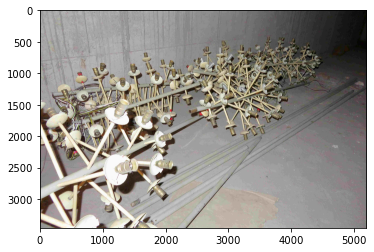

In [140]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from tqdm import tqdm

%matplotlib inline

def get_image(image_path):
    image_path = str(image_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

COLORS = {
    'pink': [255, 20, 147],
    'red': [255, 0, 0],
    'orange': [255, 140, 0],
    'yellow': [255, 255, 0],
    'brown': [165, 42, 42],
    'green': [0, 128, 0],
    'cyan': [0, 255, 255],
    'blue': [0, 0, 255],
    'purple': [128, 0, 128],
    'white': [255, 255, 255],
    'black': [0, 0, 0]
}

def get_colors(image, num_colors, show_chart=False):
    modified_image = image
    max_width = 200
    if image.shape[0] > max_width:
        scale_factor = max_width / image.shape[1]
        dim = (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor))
        modified_image = cv2.resize(modified_image, dim)
        
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    clf = KMeans(n_clusters = num_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors

def get_color_labels(img_colors, threshold=50):
    color_labels = set()
    for img_color in img_colors:
        img_color = rgb2lab(np.uint8(np.asarray([[img_color]])))
        for color_label in COLORS:
            color = COLORS[color_label]
            color = rgb2lab(np.uint8(np.asarray([[color]])))
            diff = deltaE_cie76(img_color, color)
            if (diff < threshold):
                color_labels.add(color_label)
    return color_labels

for dc in tqdm(dcs_filtered):
    for media in dc['media']:
        path = output_path/media['path']
        if path.is_file():
            image = get_image(path)
            img_colors = get_colors(image, 3)
            color_labels = get_color_labels(img_colors)
            media['colors'] = list(color_labels)
            plt.imshow(image)

In [142]:
dc_path = output_path/"dc.json"
with open(dc_path, 'w') as f:
    f.write(json.dumps(dcs_filtered, indent=2))